# Summary of basillus subtilus series on NCBI

In [1]:
import pandas as pd
import pickle 
bsu_to_gene = pickle.load( open( "bsu_to_gene.dict", "rb" ) )
gene_to_bsu = pickle.load( open( "gene_to_bsu.dict", "rb" ) )

results = []
with open('basillus_summary.txt', 'rb') as f:
    items = f.read().decode('utf-8').split("\r\n\r\n") 
for item in items:
    result = {}
    item = item.split("\r\n")
    result["title"] = item[0]
    result["submitter_supplied"] = item[1].replace("(Submitter supplied) ", "")
    result["organisms"] = item[2].split("\t")[1]
    result["type"] = item[3].split("\t")[2]
    result["samples"] = int(item[4].split()[-2])
    if "SRA" in item[6]:
        result["series_accession"] = item[7].split()[2]
        result["series_id"] = item[7].split()[4]
    else:
        result["series_accession"] = item[6].split()[2]
        result["series_id"] = item[6].split()[4]
    results.append(result) 
df = pd.DataFrame(data=results)         

In [2]:
df

,organisms,samples,series_accession,series_id,submitter_supplied,title,type
0,Staphylococcus aureus; Bacillus subtilis,16,GSE108295,200108295,Endonucleolytic cleavage within polycistronic ...,1. Maturation of polycistronic mRNA by RNase Y...,Other
1,Vibrio natriegens NBRC 15636 = ATCC 14048 = DS...,21,GSE95211,200095211,Coexpression of proteins in response to pathwa...,2. Evolutionary Convergence of Pathway-specifi...,Other
2,Bacillus subtilis,9,GSE111577,200111577,The cold shock response of B. subtilis was def...,3. The cold shock response of Bacillus subtili...,Expression profiling by high throughput sequen...
3,Bacillus amyloliquefaciens; Bacillus subtilis,112,GSE108659,200108659,The transcriptome of 8 strains were studied du...,4. Analysis of differential gene expression du...,Expression profiling by high throughput sequen...
4,Pseudomonas aeruginosa; Bacillus subtilis; Can...,18,GSE106133,200106133,RNAs are well-suited to act as cellular sensor...,5. Genome-wide identification of natural RNA a...,Expression profiling by high throughput sequen...
5,Escherichia coli; Bacillus subtilis subsp. sub...,58,GSE84421,200084421,The objective of the study was to determine th...,6. Expression profiles of Bacillus subtilis st...,Expression profiling by array
6,Caenorhabditis elegans,13,GSE95636,200095636,Young adult N2 Caenorhabditis elegans were inf...,7. Caenorhabditis elegans infected with Entero...,Expression profiling by array
7,Bacillus subtilis,5,GSE94788,200094788,The cell division protein SepF aligns polymers...,8. Free SepF blocks recruitment of late cell d...,Expression profiling by array
8,Bacillus subtilis,12,GSE104816,200104816,With these experiments we investigate the impa...,9. Transcriptional profiling of Bacillus subti...,Expression profiling by high throughput sequen...
9,Geobacillus stearothermophilus; Bacillus subti...,23,GSE98874,200098874,CCA-adding enzymes are highly specific RNA pol...,10. Cold adaptation of tRNA nucleotidyltransfe...,Expression profiling by high throughput sequen...


In [3]:
import itertools

#leave out experiments which have more than 1 organism and sort by samples
df = df[~df['organisms'].str.contains(";") & df['organisms'].str.contains("Bacillus subtilis")].sort_values("samples", ascending=False)

#make a list of the accessions to use with GEOparse
accessions_list = list(itertools.chain(*df[['series_accession']].values.tolist()))

In [4]:
import urllib.request
import os.path


def download_soft(experiment):
    fname = 'data/'+experiment+'_family.soft.gz'
    if not os.path.isfile(fname):
        urllib.request.urlretrieve('https://ftp.ncbi.nlm.nih.gov/geo/series/'+experiment[:-3]+'nnn/'+experiment+'/soft/'+experiment+'_family.soft.gz', fname)
    
#Download all SOFT files
#takes some time..
#~330 MB
for ex in accessions_list:
    download_soft(ex)

In [5]:
import GEOparse
import random
import numpy as np

GEOparse.set_verbosity('ERROR')

def read_experiment(experiment):
    return GEOparse.get_GEO(filepath="data/" + experiment + "_family.soft.gz")


def get_extra_columns(gsm, ex):
    #find column description of random sample
    extra_column = {}
    extra_column["series_accession"] = ex
    values = gsm.gsms[list(gsm.gsms)[0]].columns['description'].values
    if 'VALUE' in gsm.gsms[list(gsm.gsms)[0]].columns.index:
        extra_column["value_description"] = gsm.gsms[list(gsm.gsms)[0]].columns['description'].VALUE
    else:
        extra_column["value_description"] = ""
    if 'PRE_VALUE' in gsm.gsms[list(gsm.gsms)[0]].columns.index:
        extra_column["pre_value"] = gsm.gsms[list(gsm.gsms)[0]].columns['description'].PRE_VALUE
    else:
        extra_column["pre_value"] = "" 
        
    sample_df = gsm.gsms[list(gsm.gsms)[0]].table
    row_list = []
    for index, row in sample_df.iterrows():
        if row['ID_REF'] in bsu_to_gene:
            row_list.append([row["ID_REF"],row['VALUE']])
        elif row['ID_REF'].lower() in gene_to_bsu:
            row_list.append([row["ID_REF"],row['VALUE']])
    sample_df = pd.DataFrame(row_list, columns=["ID_REF", "VALUE"])
    values = pd.Series(sample_df["VALUE"])
    extra_column["count"] = values.count()
    if extra_column["count"] == 0:
        extra_column["count"] = np.nan
    
    extra_column["mean"] = values.mean()
    extra_column["standard_deviation"] = values.std()
    return extra_column

#this takes some time...
extra_columns = []
for ex in accessions_list:
    try:
        gsm = read_experiment(ex)
        extra_column = get_extra_columns(gsm, ex)
    except:
        extra_column = {}
    extra_columns.append(extra_column)
    

df_extra = pd.DataFrame(extra_columns)
df = df.join(df_extra.set_index('series_accession'), on="series_accession")

C:\Users\pim_d\Anaconda3\lib\site-packages\GEOparse\GEOparse.py:332: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  return DataFrame.from_csv(StringIO(data), index_col=None, sep="\t")


<IPython.core.display.Javascript object>


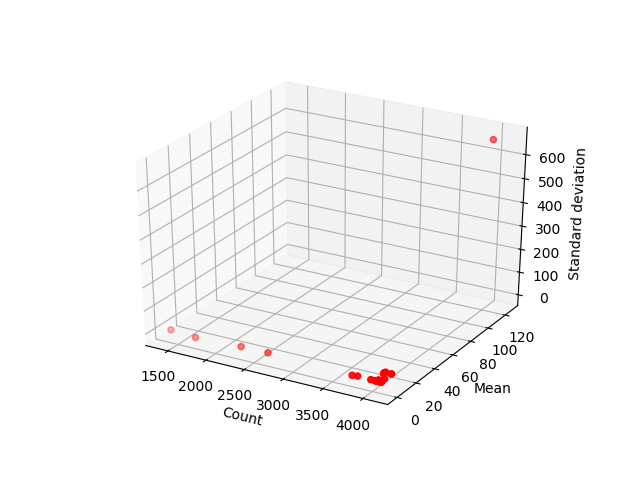

In [6]:
#make a scatter plot
%matplotlib notebook
#%matplotlib qt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def make_scatter_plot(df):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x =df["count"]
    y =df["mean"]
    z =df["standard_deviation"]
    
    ax.scatter(x, y, z, c='r', marker='o')
    ax.set_xlabel('Count')
    ax.set_ylabel('Mean')
    ax.set_zlabel('Standard deviation')

    plt.show()

df = df.dropna()    
make_scatter_plot(df)

In [7]:
df["mean"].nlargest(8)

205    125.723708
94      11.090786
20      10.612957
7       10.597968
50      10.536337
55       9.998146
57       9.998146
56       9.228778
Name: mean, dtype: float64

<IPython.core.display.Javascript object>


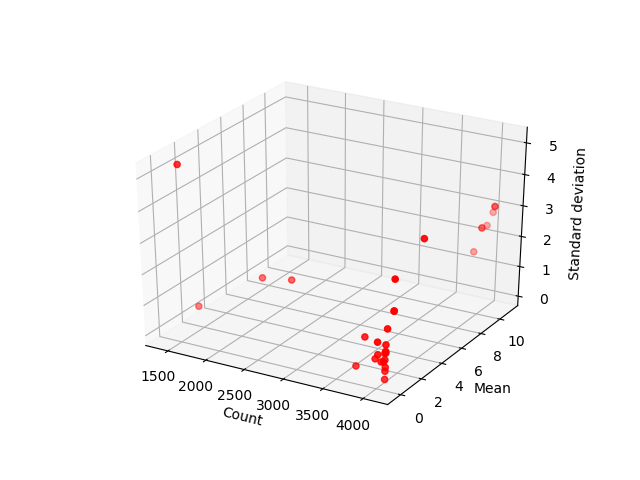

In [8]:
df = df.drop(df["mean"].nlargest(1).index)
make_scatter_plot(df)

In [9]:
df["count"].nsmallest(10)

202    1401.0
110    1739.0
117    2312.0
90     2655.0
80     3746.0
62     3810.0
92     3978.0
55     4025.0
50     4025.0
56     4025.0
Name: count, dtype: float64

<IPython.core.display.Javascript object>


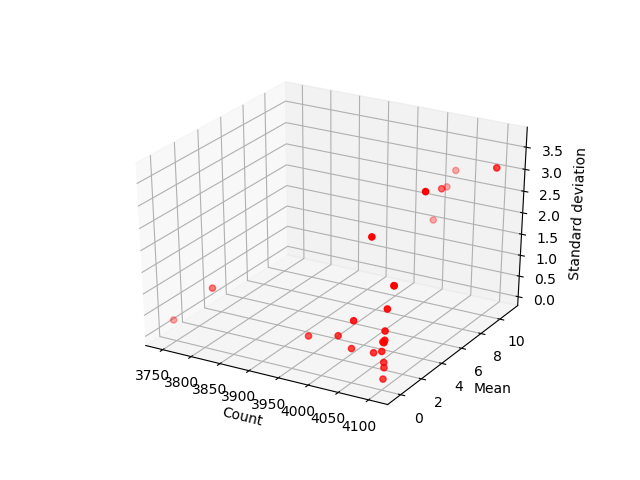

In [10]:
df = df.drop(df["count"].nsmallest(4).index)
make_scatter_plot(df)

<IPython.core.display.Javascript object>


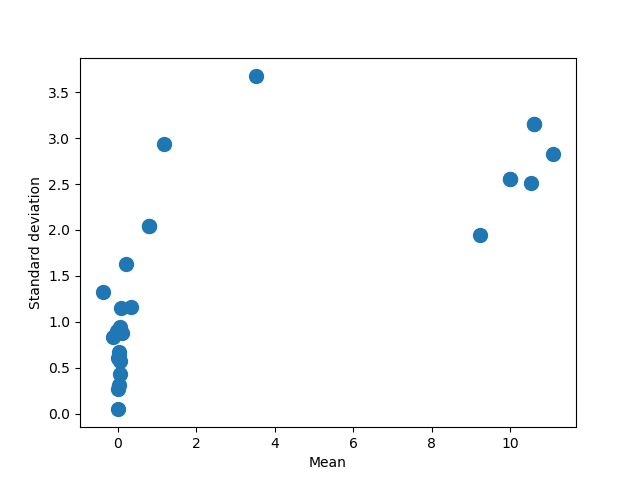

In [11]:
#Now show without count
x = df["mean"].values
y = df["standard_deviation"].values
names = df["series_accession"].values

norm = plt.Normalize(1,4)
cmap = plt.cm.RdYlGn

fig,ax = plt.subplots()
sc = plt.scatter(x,y,s=100, cmap=cmap, norm=norm)

ax.set_xlabel('Mean')
ax.set_ylabel('Standard deviation')

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format(", ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()

In [12]:
#remove weird GSE34383 and GSE9266
df = df.drop(df[df["series_accession"] == "GSE34383"].index)
df = df.drop(df[df["series_accession"] == "GSE9266"].index)


<IPython.core.display.Javascript object>


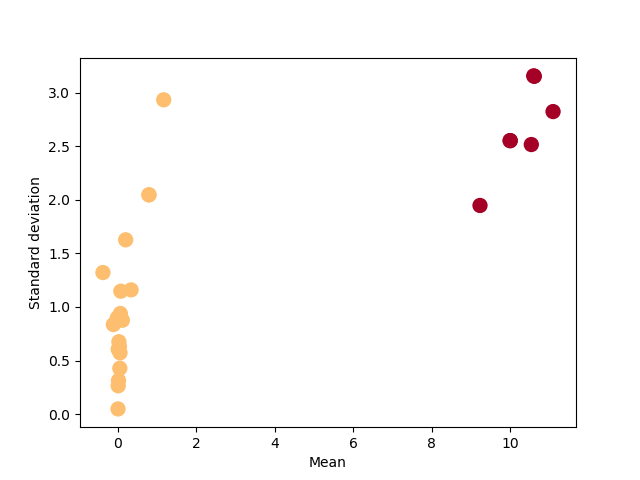

In [13]:
#do kmeans with 2.
#now show 1 without the count
from sklearn.cluster import KMeans

train = df[["mean", "standard_deviation"]].values
kmeans = KMeans(n_clusters=2, random_state=0).fit(train)

labels = kmeans.labels_

x = train[:, 0]
y = train[:, 1]
names = df["series_accession"].values

norm = plt.Normalize(1,4)
cmap = plt.cm.RdYlGn
labels = kmeans.labels_
c = labels*2
fig,ax = plt.subplots()
sc = plt.scatter(x,y, c=c,s=100, cmap=cmap, norm=norm)

ax.set_xlabel('Mean')
ax.set_ylabel('Standard deviation')

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format(", ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()

In [14]:
df = df.reset_index(drop=True)
df_labels = pd.Series(labels, name="cluster")
df = df.join(df_labels)

In [15]:
df[df["cluster"] == 1]

,organisms,samples,series_accession,series_id,submitter_supplied,title,type,count,mean,pre_value,standard_deviation,value_description,cluster
0,Bacillus subtilis,268,GSE67023,200067023,Organisms from all domains of life use gene re...,63. An experimentally supported model of the B...,Expression profiling by array,3810.0,0.335735,,1.159793,normalized log2 ratio gMedianSignal/rMedianSignal,1
1,Bacillus subtilis,118,GSE19831,200019831,We have determined the time-resolved transcrip...,142. Growing pains: natural stress response du...,Expression profiling by array,4061.0,1.167885,,2.933973,normalized log2 ratio (Cy5/Cy3),1
2,Bacillus subtilis,16,GSE39142,200039142,Detailed description (other than provided belo...,94. The YmdB phosphodiesterase is a global reg...,Expression profiling by array,4086.0,0.008427,,0.605215,LN ratio (Target / Control = Mutant / Wild typ...,1
3,Bacillus subtilis,15,GSE27416,200027416,Global tranascriptional profiling of Bacillus ...,"158. Bacillus subtilis CU1065: WT vs fur, fur ...",Expression profiling by array,4060.0,-0.381211,,1.321497,log2 of mutant/average of fur,1
4,Bacillus subtilis,15,GSE30003,200030003,This SuperSeries is composed of the SubSeries ...,151. The GntR family repressor YtrA responds t...,Expression profiling by array,4104.0,0.791588,Fold changes equal to average of moenomycin tr...,2.046960,log2 of PRE_VALUE,1
5,Bacillus subtilis,14,GSE13820,200013820,Abstract of associated manuscript: The Bacillu...,191. Sigma(M) regulated genes under antibiotic...,Expression profiling by array,4103.0,-0.016908,Ratios equal to average of vancomycin treated ...,0.895852,log2 of PRE_VALUE: Ratios equal to average of ...,1
6,Bacillus subtilis,12,GSE55051,200055051,The advent of ‘omics’ techniques bear signific...,81. Time-series of transcriptome analysis of B...,Expression profiling by array,3746.0,0.007439,,0.264541,Normalized log2 ratio (Cy5/Cy3) representing t...,1
7,Bacillus subtilis,12,GSE13036,200013036,The Bacillus subtilis membrane contains diacyl...,195. Global profiling of B. subtilis comparing...,Expression profiling by array,4099.0,0.113450,,0.876261,log2 ratio representing mutant/wt,1
8,Bacillus subtilis,9,GSE47918,200047918,To compare the altered transcript levels in th...,43. Effect of floT and floA mutations on the g...,Expression profiling by array,4103.0,0.016099,,0.313967,LN ratio (target/control or mutant/wild type) ...,1
9,Bacillus subtilis subsp. subtilis str. 168,8,GSE50653,200050653,Comparing the transcriptional responses of Bac...,84. Bacillus subtilis strains at low-pressure:...,Expression profiling by array,4102.0,0.002847,,0.048081,normalized RATIO = log10(2cy5/2cy3),1


In [20]:
df

,organisms,samples,series_accession,series_id,submitter_supplied,title,type,count,mean,pre_value,standard_deviation,value_description,cluster
0,Bacillus subtilis,268,GSE67023,200067023,Organisms from all domains of life use gene re...,63. An experimentally supported model of the B...,Expression profiling by array,3810.0,0.335735,,1.159793,normalized log2 ratio gMedianSignal/rMedianSignal,1
1,Bacillus subtilis,118,GSE19831,200019831,We have determined the time-resolved transcrip...,142. Growing pains: natural stress response du...,Expression profiling by array,4061.0,1.167885,,2.933973,normalized log2 ratio (Cy5/Cy3),1
2,Bacillus subtilis,16,GSE39142,200039142,Detailed description (other than provided belo...,94. The YmdB phosphodiesterase is a global reg...,Expression profiling by array,4086.0,0.008427,,0.605215,LN ratio (Target / Control = Mutant / Wild typ...,1
3,Bacillus subtilis,15,GSE27416,200027416,Global tranascriptional profiling of Bacillus ...,"158. Bacillus subtilis CU1065: WT vs fur, fur ...",Expression profiling by array,4060.0,-0.381211,,1.321497,log2 of mutant/average of fur,1
4,Bacillus subtilis,15,GSE30003,200030003,This SuperSeries is composed of the SubSeries ...,151. The GntR family repressor YtrA responds t...,Expression profiling by array,4104.0,0.791588,Fold changes equal to average of moenomycin tr...,2.046960,log2 of PRE_VALUE,1
5,Bacillus subtilis,14,GSE13820,200013820,Abstract of associated manuscript: The Bacillu...,191. Sigma(M) regulated genes under antibiotic...,Expression profiling by array,4103.0,-0.016908,Ratios equal to average of vancomycin treated ...,0.895852,log2 of PRE_VALUE: Ratios equal to average of ...,1
6,Bacillus subtilis,12,GSE55051,200055051,The advent of ‘omics’ techniques bear signific...,81. Time-series of transcriptome analysis of B...,Expression profiling by array,3746.0,0.007439,,0.264541,Normalized log2 ratio (Cy5/Cy3) representing t...,1
7,Bacillus subtilis,12,GSE13036,200013036,The Bacillus subtilis membrane contains diacyl...,195. Global profiling of B. subtilis comparing...,Expression profiling by array,4099.0,0.113450,,0.876261,log2 ratio representing mutant/wt,1
8,Bacillus subtilis,9,GSE47918,200047918,To compare the altered transcript levels in th...,43. Effect of floT and floA mutations on the g...,Expression profiling by array,4103.0,0.016099,,0.313967,LN ratio (target/control or mutant/wild type) ...,1
9,Bacillus subtilis subsp. subtilis str. 168,8,GSE50653,200050653,Comparing the transcriptional responses of Bac...,84. Bacillus subtilis strains at low-pressure:...,Expression profiling by array,4102.0,0.002847,,0.048081,normalized RATIO = log10(2cy5/2cy3),1


In [16]:
df.to_csv("parsed_summary.csv", encoding='utf-8', index=False)